# Cluster Analysis of 2014 Boston Marathon Results

In [1]:
# Make code toggle-able for easier review.
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<i>The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a></i>.''')

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing

from sklearn.decomposition import PCA

from sklearn.cluster import MeanShift, estimate_bandwidth

from matplotlib.gridspec import GridSpec

import matplotlib.colors as mpcol

import matplotlib.patches as mpatches


In [3]:
# Import the data
df = pd.read_csv('https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2014/results.csv')

In [4]:
# Aesthetics

# Create a dictionary to hold palettes for features and variables
palettes = {}

# Set the palettes
palettes['gender'] = {0:'#c5c2f4', 1:'#e57068'} # gender
palettes['wave'] = sns.cubehelix_palette(6, start=2, reverse=True) #wave
palettes['country'] = sns.color_palette('Set1').as_hex() # nationalities
palettes['clusters'] = sns.color_palette("bright", 5) # clusters



<hr>

# 1) Investigating the raw data & engineering features

In [5]:
print('Total features: {}\n{}'.format(len(list(df)), list(df)))
print('\nData type is object: {}\n{}'.format(len(list(df.describe(include=[np.object]))),
                                            list(df.describe(include=[np.object]))))
print('\nData type is number: {}\n{}'.format(len(list(df.describe(include=[np.number]))), 
                                            list(df.describe(include=[np.number]))))

pd.set_option('display.max_columns', 500)
df.head(n=3)

Total features: 21
['10k', 'name', 'division', '25k', 'gender', 'age', 'official', 'bib', 'genderdiv', 'ctz', '35k', 'overall', 'pace', 'state', '30k', '5k', 'half', '20k', 'country', 'city', '40k']

Data type is object: 15
['10k', 'name', '25k', 'gender', 'bib', 'ctz', '35k', 'state', '30k', '5k', 'half', '20k', 'country', 'city', '40k']

Data type is number: 6
['division', 'age', 'official', 'genderdiv', 'overall', 'pace']


,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,35k,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,71.40,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,116.37,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,67.42,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10


### __'name'__ and __'age'__ are self-explanatory. I've engineered age bracket for the sake of a more useful visualization.
> The Boston marathon divides its qualifying times into 5 year age brackets, so those are the buckets I'll use for feature engineering and visualization.
<br><br>
<i>For more information, see: https://www.baa.org/races/boston-marathon/enter/qualify/history-qualifying-times</i>

In [6]:
# Define age brackets
age_definitions = {'18-34':(18,34),
                   '35-39':(35,39),
                   '40-44':(40,44),
                   '45-49':(45,49),
                   '50-54':(50,54),
                   '55-59':(55,59),
                   '60-64':(60,64),
                   '65-70':(65,70),
                   '70-74':(70,74),
                   '75-80':(75,80),
                   '80+':(80,df['age'].max())}

# Add the color palette for age
palettes['age'] = sns.cubehelix_palette(len(age_definitions), reverse=True)

# Define a function to convert ages to brackets
def convert_age(x):    
    for key in age_definitions: 
        if age_definitions[key][0] <= x <= age_definitions[key][1]: return key               
    else: 
        print('Could not bucket age for value {}'.format(x))
        return np.nan

# Create a column for age bracket
df['age_bracket'] = df['age'].apply(lambda x: convert_age(x))

### __'5k'__, __'10k'__, __'15k'__, __'half'__, __'25k'__, __'30k'__, __'35k'__, __'40k'__, and __'official'__ represent distance checkpoints in the race. Some of them are mistakenly formatted as strings in the raw data.

In [7]:
# Clean the columns that are currently strings
for col in ['5k', '10k', '20k', 'half', '25k', '30k', '35k', '40k', 'official']:
    try: df[col] = df[col].str.replace('-','0.0').astype(float)
    except AttributeError: pass
    except ValueError: pass

### __'division'__ represents an individual's position within their division – division itself isn't included in the raw data, but could perhaps be approximated with clustering. Participants from 23 divisions finished the race. 

In [8]:
print('Participants from {} divisions finished the race.'.format(df['division'].value_counts()[:1].sum()))

Participants from 23 divisions finished the race.


### I engineered __'gender'__ into a binary is_female feature to make it more useful. __'genderdiv'__ represents an individual's finishing position in their gender division.

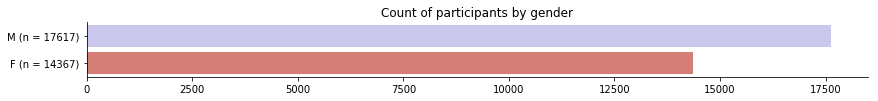

In [9]:
# Define the y labels for the visualization
labels = ['{} (n = {})'.format(gender, df[df['gender'] == gender].shape[0]) for gender in df['gender'].unique()]

# Change gender to a binary variable
df = pd.get_dummies(df,columns=['gender'])

# Plot the figure
plt.figure(figsize=(14,1))
sns.countplot(y=df['gender_F'], palette=palettes['gender'])
sns.despine()
plt.title('Count of participants by gender')
plt.xlabel('')
plt.ylabel('')
plt.yticks([0,1], labels)
plt.show()

### __'bib'__ is the number printed on a participant's bib. It contains information about a participant's start wave.
> Bib numbers indicate what wave of the race the participant was assigned to, and, accordingly, what time of day 
they began the race. Participants whose bib began with F were assigned to the women's elite wave, while participants whose bib began with W were assigned to the men's elite wave.
<br><br><i>For more information, refer to: http://registration.baa.org/2014/cf/Public/iframe_EntryLists.cfm</i>

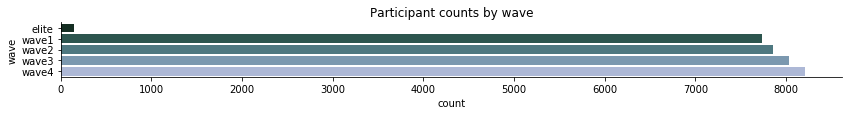

In [10]:
# Define waves
wave_definitions = {'elite':(0,100),
                    'wave1':(101,8999),
                    'wave2':(9000,17999),
                    'wave3':(18000,26999),
                    'wave4':(27000, 40000)}

# Define a function to convert bibs to waves
def convert_bib(x):    
    try:
        for key in wave_definitions:
            if wave_definitions[key][0] <= float(x) <= wave_definitions[key][1]: return key             
    except ValueError:   
        if 'W' in str(x): return 'elite'
        elif 'F' in str(x): return 'elite'    
    else: 
        print(float(x))
        return np.nan

# Create a wave column
df['wave'] = df['bib'].apply(lambda x: convert_bib(x))



# Plot the figure
plt.figure(figsize=(14,1))
sns.countplot(y=df['wave'], palette=palettes['wave'])
sns.despine()
plt.title('Participant counts by wave')
plt.show()

###  __'country'__ and __'state'__ contain information about where participants are from.

In [11]:
print('Unique countries: {}\n{}'.format(len(df['country'].unique()), df['country'].unique()))

print('\nUnique states: {}\n{}'.format(len(df['state'].unique()), df['state'].unique()))

Unique countries: 78
['JPN' 'KEN' 'RSA' 'ETH' 'SUI' 'USA' 'FRA' 'CAN' 'ESP' 'POL' 'RUS' 'BLR'
 'MAR' 'UKR' 'BRA' 'THA' 'CHN' 'ITA' 'GER' 'GBR' 'AUS' 'SWE' 'GRE' 'SLO'
 'IRL' 'KOR' 'ARG' 'COL' 'NED' 'ISR' 'CZE' 'NOR' 'AUT' 'CRC' 'MEX' 'GUA'
 'SIN' 'DEN' 'HUN' 'BEL' 'FIN' 'CHI' 'ISL' 'VEN' 'DOM' 'PER' 'HKG' 'SVK'
 'NZL' 'TPE' 'PHI' 'CAY' 'POR' 'UAE' 'IND' 'PAN' 'ROU' 'LUX' 'ESA' 'TRI'
 'MAS' 'VGB' 'EGY' 'BRN' 'EST' 'ECU' 'LIE' 'TUR' 'BOL' 'BAR' 'URU' 'QAT'
 'INA' 'BER' 'TAN' 'BAH' 'CRO' 'ZIM']

Unique states: 69
[nan 'CA' 'ON' 'MI' 'QC' 'IL' 'OR' 'AZ' 'CO' 'VA' 'GA' 'NJ' 'ME' 'MA' 'UT'
 'NY' 'MO' 'RI' 'NH' 'MT' 'KY' 'FL' 'TN' 'AB' 'WA' 'WI' 'DC' 'PA' 'OH'
 'IN' 'NS' 'MD' 'IA' 'MN' 'CT' 'SD' 'TX' 'DE' 'LA' 'NC' 'OK' 'NV' 'AL'
 'KS' 'NE' 'MB' 'HI' 'AK' 'NM' 'BC' 'VT' 'ID' 'SC' 'WV' 'PE' 'ND' 'MS'
 'AR' 'SK' 'NT' 'PR' 'WY' 'NB' 'YT' 'NL' 'AE' 'AA' 'AP' 'GU']


###  __'pace'__ is derived from __'official'__, and describes a participant's pace over the course of the race in mph. To validate this assumption, I derived __'distance'__ by multiplying __'pace'__ by __'official'__, then mean and standard deviation against the expected ~26.22 mile distance of the Boston Marathon.

In [12]:
df['distance'] = round(df['official'] / df['pace'],2)
print('Mean distance: {}\n'.format(round(df['distance'].mean(),2)) +
      'Standard deviation: {}'.format(round(df['distance'].std(),2)))

Mean distance: 26.2
Standard deviation: 0.05


<hr>

# 2) Relationships between demographics & checkpoint completion time

### Checkpoint completion time by gender

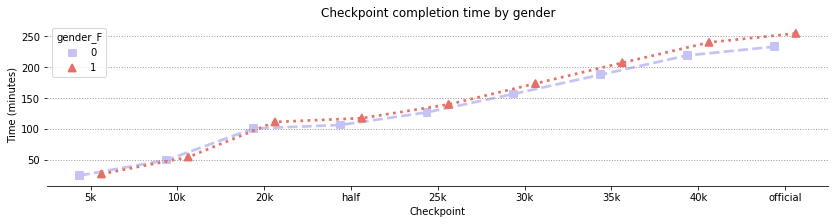

In [13]:
stacked_checkpoints = pd.melt(df,
                              value_vars=['5k', '10k', '20k', 'half', '25k', '30k', '35k', '40k', 'official'],
                              var_name='checkpoint',
                              value_name='time',
                              id_vars=['gender_F'])

plt.figure(figsize=(14,3))
ax = sns.pointplot(data=stacked_checkpoints,
            x='checkpoint',
            y='time',
            hue='gender_F',
            markers=[',','^'],
            linestyles=['--', ':'],
            palette=palettes['gender'],
            ci=95,
            orient="v",
            dodge=0.25)

ax.grid(color='grey', linestyle=':', linewidth=1, axis='y', alpha=0.8)
sns.despine(left=True)

plt.title('Checkpoint completion time by gender')
plt.ylabel('Time (minutes)')
plt.xlabel('Checkpoint')

plt.show()

In [14]:
# Print some descriptive statistics to provide further information
f_n = df[df['gender_F'] == 1]['official'].shape[0]
f_avg = round(df[df['gender_F'] == 1]['official'].mean(),2)
f_std = round(df[df['gender_F'] == 1]['official'].std(),2)
print('There were {} female participants in the Boston Marathon.\nOn average, they finished the race in'
      ' {} minutes (standard deviation = {})'.format(f_n, f_avg, f_std))

m_n = df[df['gender_F'] == 0]['official'].shape[0]
m_avg = round(df[df['gender_F'] == 0]['official'].mean(),2)
m_std = round(df[df['gender_F'] == 0]['official'].std(),2)
print('\nThere were {} male participants in the Boston Marathon.\nOn average, they finished the race in'
      ' {} minutes (standard deviation = {})'.format(m_n, m_avg, m_std))

There were 14367 female participants in the Boston Marathon.
On average, they finished the race in 254.83 minutes (standard deviation = 48.42)

There were 17617 male participants in the Boston Marathon.
On average, they finished the race in 233.34 minutes (standard deviation = 53.36)


<br>
### Checkpoint completion time by country
> Participants from 78 countries were represented in the 2014 Boston Marathon, but only the United States, Canada, Great Britain, Italy, and Mexico had over 200 representatives. For the sake of the visualization's clarity, I've only included those 5 countries.

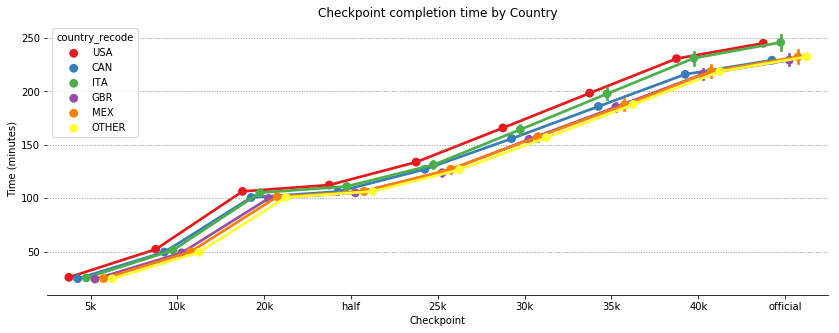

In [15]:
# Aggregate countries with fewer than 200 racers as 'other country' in a recoded column.
other_countries = df['country'].value_counts().index.tolist()[5:]
df['country_recode'] = df['country'].apply(lambda x: np.where(x in other_countries, 'OTHER', x))

# Make the completion times tidy for easier visualization
stacked_checkpoints = pd.melt(df,
                              value_vars=['5k', '10k', '20k', 'half', '25k', '30k', '35k', '40k', 'official'],
                              var_name='checkpoint',
                              value_name='time',
                              id_vars=['country_recode'])

# Plot the figure
plt.figure(figsize=(14,5))
ax = sns.pointplot(data=stacked_checkpoints,
            x='checkpoint',
            y='time',
            hue='country_recode',
            hue_order=['USA', 'CAN', 'ITA', 'GBR', 'MEX', 'OTHER'],
            palette=palettes['country'],
            ci=95,
            orient="v",
            dodge=0.5)

ax.grid(color='grey', linestyle=':', linewidth=1, axis='y', alpha=0.8)
sns.despine(left=True)

plt.title('Checkpoint completion time by Country')
plt.ylabel('Time (minutes)')
plt.xlabel('Checkpoint')

plt.show()

In [16]:
# Define a function to streamline descriptive statistic retrieval
def get_descriptives(column, category):
    c_n = df[df[column] == category]['official'].shape[0]
    c_avg = round(df[df[column] == category]['official'].mean(),2)
    c_std = round(df[df[column] == category]['official'].std(),2)    
    print('There were {} {} participants in the 2014 Boston Marathon.\nOn average, they finished the race in'
          ' {} minutes (standard deviation = {})\n'.format(c_n, category, c_avg, c_std))    

# Print some descriptive statistics to provide further information
for country in ['USA', 'CAN', 'ITA', 'GBR', 'MEX']:
    get_descriptives('country', country)

There were 27233 USA participants in the 2014 Boston Marathon.
On average, they finished the race in 245.05 minutes (standard deviation = 53.11)

There were 2175 CAN participants in the 2014 Boston Marathon.
On average, they finished the race in 229.12 minutes (standard deviation = 39.4)

There were 212 ITA participants in the 2014 Boston Marathon.
On average, they finished the race in 245.84 minutes (standard deviation = 49.5)

There were 346 GBR participants in the 2014 Boston Marathon.
On average, they finished the race in 229.23 minutes (standard deviation = 47.31)

There were 205 MEX participants in the 2014 Boston Marathon.
On average, they finished the race in 232.24 minutes (standard deviation = 44.78)



### Checkpoint completion time by wave: 

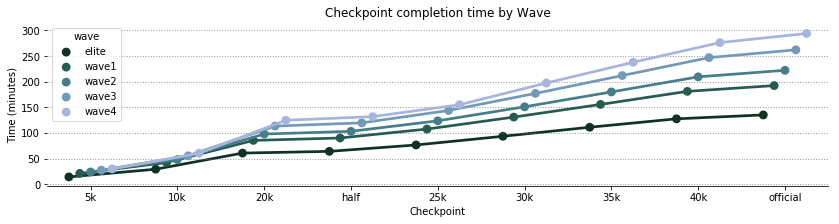

In [17]:
# Make the checkpoint completion times tidy for easier visualization
stacked_checkpoints = pd.melt(df,
                              value_vars=['5k', '10k', '20k', 'half', '25k', '30k', '35k', '40k', 'official'],
                              var_name='checkpoint',
                              value_name='time',
                              id_vars=['wave'])

# Visualize checkpoint completion time by wave
plt.figure(figsize=(14,3))
ax = sns.pointplot(data=stacked_checkpoints,
            x='checkpoint',
            y='time',
            hue='wave',
            palette=palettes['wave'],
            ci=95,
            orient="v",
            dodge=0.5)

ax.grid(color='grey', linestyle=':', linewidth=1, axis='y', alpha=0.8)
sns.despine(left=True)

plt.title('Checkpoint completion time by Wave')
plt.ylabel('Time (minutes)')
plt.xlabel('Checkpoint')

plt.show()

In [18]:
# Print some descriptive statistics to provide further information
for wave in df['wave'].unique():
    get_descriptives('wave', wave)

There were 147 elite participants in the 2014 Boston Marathon.
On average, they finished the race in 135.2 minutes (standard deviation = 29.25)

There were 7741 wave1 participants in the 2014 Boston Marathon.
On average, they finished the race in 192.37 minutes (standard deviation = 22.52)

There were 7860 wave2 participants in the 2014 Boston Marathon.
On average, they finished the race in 222.16 minutes (standard deviation = 23.31)

There were 8028 wave3 participants in the 2014 Boston Marathon.
On average, they finished the race in 262.05 minutes (standard deviation = 39.93)

There were 8208 wave4 participants in the 2014 Boston Marathon.
On average, they finished the race in 293.99 minutes (standard deviation = 45.71)



### Checkpoint completion time by age bracket

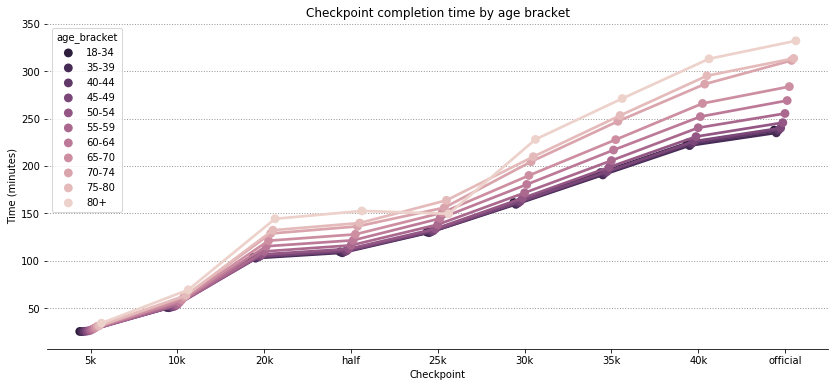

In [19]:
# Make the age brackets tidy for easier visualization
stacked_checkpoints = pd.melt(df,
                              value_vars=['5k', '10k', '20k', 'half', '25k', '30k', '35k', '40k', 'official'],
                              var_name='checkpoint',
                              value_name='time',
                              id_vars=['age_bracket'])



# Visualize checkpoint completion time by wave
plt.figure(figsize=(14,6))
ax = sns.pointplot(data=stacked_checkpoints,
            x='checkpoint',
            y='time',
            hue='age_bracket',
            hue_order=list(age_definitions.keys()),
            palette=palettes['age'],
            ci=None,
            orient="v",
            dodge=0.25)

ax.grid(color='grey', linestyle=':', linewidth=1, axis='y', alpha=0.8)
sns.despine(left=True)

plt.title('Checkpoint completion time by age bracket')
plt.ylabel('Time (minutes)')
plt.xlabel('Checkpoint')

plt.show()

Participants in each age bracket performed, on average, better than the participants in the next-oldest age bracket and worse than participants in the next-youngest age bracket. However, this distinction is much less pronounced between participants under 50 years of age.

<hr>

# 3) Modeling

In [20]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

### Finalizing features

In [21]:
# Create a new dataframe for features
features = pd.DataFrame()

# Rescale age from 0-1.
features['age'] = df['age']

# Add gender to the feature set.
features['is_female'] = df['gender_F']

# Add countries with over 200 participants as binary columns.
for country in ['USA', 'CAN', 'ITA', 'GBR', 'MEX', 'OTHER']:
    features[country] = np.where(df['country'] == country, 1, 0)
    
# Add waves as binary columns.
for wave in df['wave'].unique():
    features[wave] = np.where(df['wave'] == wave, 1, 0)
    
# Rescale and add overall finishing position.
features['overall'] = df['overall']

# Rescale and add division finishing position.
features['division'] = df['division']

# Rescale and add gender division finishing position.
features['genderdiv'] = df['genderdiv']

# Add checkpoint times.
for col in ['5k', '10k', '20k', 'half', '25k', '30k', '35k', '40k', 'official']:
    features[col] = df[col]
    
features.head(n=3)

,age,is_female,USA,CAN,ITA,GBR,MEX,OTHER,elite,wave1,wave2,wave3,wave4,overall,division,genderdiv,5k,10k,20k,half,25k,30k,35k,40k,official
0,47,0,0,0,0,0,0,0,1,0,0,0,0,8,8,8,8.02,17.37,37.65,39.72,47.67,59.18,71.40,80.43,85.25
1,33,1,0,0,0,0,0,0,1,0,0,0,0,21,1,1,16.22,32.58,65.83,69.47,82.43,99.33,116.37,132.10,138.95
2,41,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,7.75,16.62,36.10,38.03,45.80,56.45,67.42,76.10,80.60


### Normalizing the data to account for differences in scale between my features

In [22]:
# Define X
X = features

# Normalize the data
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X_normed = pd.DataFrame(np_scaled, columns=list(features))
X_normed.head(n=3)

,age,is_female,USA,CAN,ITA,GBR,MEX,OTHER,elite,wave1,wave2,wave3,wave4,overall,division,genderdiv,5k,10k,20k,half,25k,30k,35k,40k,official
0,0.460317,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000219,0.001003,0.000398,0.092237,0.154565,0.167818,0.167829,0.164937,0.157235,0.158903,0.158218,0.010147
1,0.238095,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000626,0.000000,0.000000,0.186544,0.289909,0.293425,0.293531,0.285205,0.263909,0.258986,0.259860,0.127324
2,0.365079,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.089132,0.147891,0.160909,0.160688,0.158467,0.149981,0.150046,0.149700,0.000000


### Performing PCA for graphing purposes

In [23]:
# Perform PCA for graphing purposes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normed)
pca_1 = [x[0] for x in X_pca]
pca_2 = [x[1] for x in X_pca]

X_pca

array([[ 0.91630293, -0.04239324],
       [ 0.43514148, -0.5669596 ],
       [ 0.92615298, -0.04207286],
       ...,
       [-0.91795314,  0.37234912],
       [-1.02401914,  0.41025456],
       [-0.23802152,  0.76732535]])

### I'm utilizing mean shift clustering for my first pass at this data – spectral & affinity propagation are too expensive for a dataset of this size, and K means won't work because (1) I don't know K, and (2) I don't know whether or not the clusters are globular.

In [24]:
### Mean Shift
# Set bandwidth
bandwidth = estimate_bandwidth(X_normed, 
                               quantile=0.2, 
                               n_samples=500, 
                               n_jobs=1)
# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth,
               bin_seeding=True)
ms.fit(X_normed)
ms_labels = ms.predict(X_normed)

ms

MeanShift(bandwidth=1.3323390819961933, bin_seeding=True, cluster_all=True,
     min_bin_freq=1, n_jobs=1, seeds=None)

### Visualizing the clusters

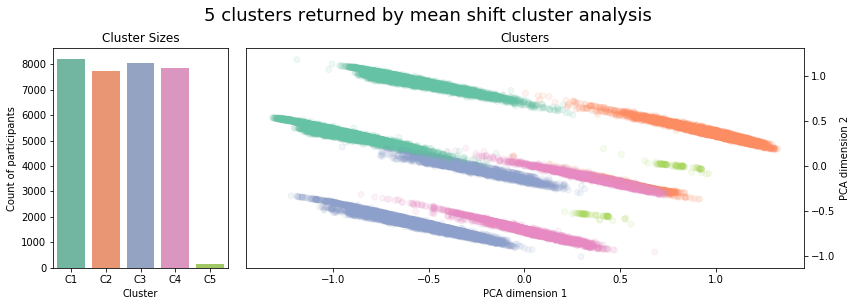

In [25]:
# Add the clusters to the dataframes
features['cluster'] = ms_labels + 1
df['cluster'] = ms_labels + 1

# Set the cluster palette
palettes['clust_rgb'] = sns.color_palette('Set2', 5).as_hex()
palettes['clust_cmap'] = mpcol.ListedColormap(palettes['clust_rgb'], name='my_name')

plt.figure(figsize=(12,4))
gs = GridSpec(1, 8)

# Create a plot that'll do double duty by labeling the clusters by color & describing their sizes
ax1 = plt.subplot(gs[0, 0:2])    
sns.countplot(x=features['cluster'],
              palette=sns.color_palette(palettes['clust_rgb']))

plt.title('Cluster Sizes')
plt.xlabel('Cluster')
plt.ylabel('Count of participants')
cluster_labels = ['C{}'.format(x) for x in range(1,6)]
ax1.set_xticklabels(cluster_labels)

# Visualize the blobs
ax2 = plt.subplot(gs[0, 2:])    
plt.scatter(x=pca_1,
            y=pca_2,
            c=features['cluster'],
            cmap=palettes['clust_cmap'],
            alpha=0.1)
plt.title('Clusters')
plt.xlabel('PCA dimension 1')
plt.ylabel('PCA dimension 2')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")


plt.suptitle('{} clusters returned by mean shift cluster analysis'.format(len(set(ms_labels))), fontsize=18, y=1.05)

plt.tight_layout()
plt.show()

### Because I don't have a ground truth, I'm evaluating using silhouette coefficients.

In [26]:
# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_normed,
    X_pca,
    test_size=0.5,
    random_state=42)

# Then we halve the halves.
X1, X2, X_pca1, X_pca2 = train_test_split(
    X_half1,
    X_pcahalf1,
    test_size=0.5,
    random_state=42)
X3, X4, X_pca3, X_pca4 = train_test_split(
    X_half2,
    X_pcahalf2,
    test_size=0.5,
    random_state=42)

from sklearn import metrics
from sklearn.metrics import pairwise_distances

counter = 0
for sample in [X1, X2, X3, X4]:
    model = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(sample)
    labels = model.labels_
    counter += 1
    print('Silhouette coefficient for sample {}: {}'.format(counter, round(metrics.silhouette_score(sample, labels, metric='euclidean'),4)))

Silhouette coefficient for sample 1: 0.4697
Silhouette coefficient for sample 2: 0.4739
Silhouette coefficient for sample 3: 0.4696
Silhouette coefficient for sample 4: 0.4702


> These scores are pretty consistent across the splits - my model is consistently producing clusters with points that are closer to each other than they are to other datapoints. That feels like solid ground to move forward on.

<hr>

# 4) Cluster Summaries

## Demographics

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


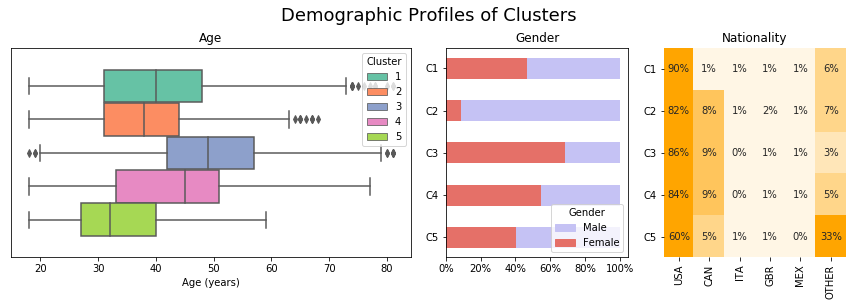

In [27]:
# Plot a figure summarizing demographics by cluster
fig = plt.figure(figsize=(12,4))
gs = GridSpec(1, 4)


### Age
features['y'] = 1 # Add a dummy column for plotting in-place

ax1 = plt.subplot(gs[0, 0:2])    
sns.boxplot(y='y',
            x='age',
            data=features,
            hue='cluster',
            palette=sns.color_palette(palettes['clust_rgb']),
            orient='h',
           saturation=1)

ax1.axes.get_yaxis().set_visible(False)

plt.title('Age')
plt.xlabel('Age (years)')

plt.legend(loc="upper right",
           title='Cluster')


### Gender
ax2 = plt.subplot(gs[0, 2:3])
for cluster in np.arange(6):
    f_percent = features[features['cluster'] == cluster]['is_female'].mean()
    m_percent = 1 - features[features['cluster'] == cluster]['is_female'].mean()
    f_std = features[features['cluster'] == cluster]['is_female'].std()
    m_std = 1 - features[features['cluster'] == cluster]['is_female'].std()    
    
    p1 = plt.barh(cluster, f_percent, 0.5, color=palettes['gender'][1])
    p2 = plt.barh(cluster, m_percent, 0.5, left=f_percent, color=palettes['gender'][0])

plt.gca().invert_yaxis()
ax2.set_yticklabels([''] + cluster_labels)
ax2.set_xticklabels(['{}%'.format(tick) for tick in np.arange(0,120,20)])

gender_legend = [mpatches.Patch(color=palettes['gender'][0], label='Male'),
                 mpatches.Patch(color=palettes['gender'][1], label='Female')]
plt.legend(handles=gender_legend, 
           loc="lower right",
           title='Gender')
plt.title('Gender')


### Nationality

# Define a list of countries and shape the data for visualization
countries = ['USA', 'CAN', 'ITA', 'GBR', 'MEX', 'OTHER']
ctry_data = {}
for cluster in np.arange(1,6):
    ctry_data[cluster] = [(df[(df['cluster'] == cluster) & (df['country_recode'] == country)]['country_recode'].count())
                          /df[df['cluster'] == cluster].shape[0] for country in countries]
# Visualize the data
ax3 = plt.subplot(gs[0, 3:4])
sns.heatmap(pd.DataFrame(ctry_data, index=countries).transpose(), 
                 annot=True,
                 fmt=".0%",
                 cmap=sns.light_palette("orange"),
                 cbar=False,
                 vmin=0, 
                 vmax=0.15)

plt.yticks(rotation=0) 
cluster_labels = ['C{}'.format(x) for x in range(1,6)]
ax3.set_yticklabels(cluster_labels)

plt.title('Nationality')


# Define overall aesthetics and plot.
plt.suptitle('Demographic Profiles of Clusters',fontsize=18, y=1.05)
plt.tight_layout()
plt.show()

## Performance

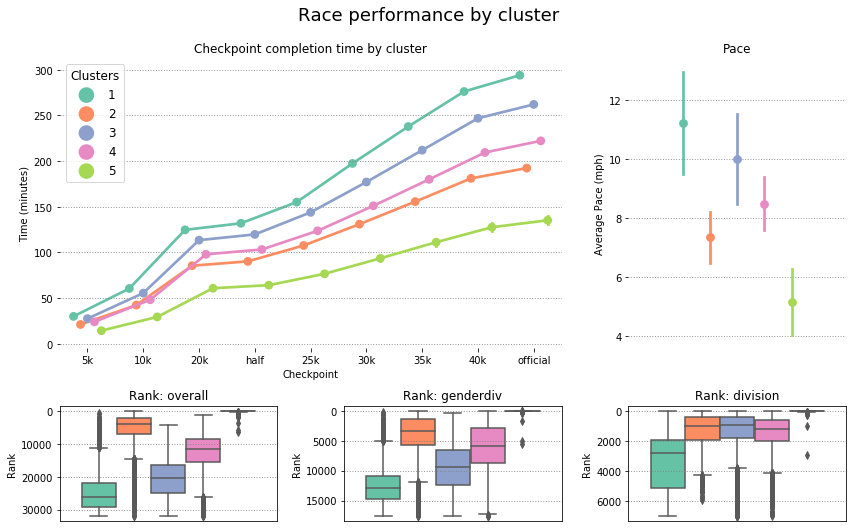

In [28]:
# Plot a figure summarizing race performance across clusters
gs = GridSpec(3, 3)
plt.figure(figsize=(12,7))

### Checkpoints

# Tidy the data for easier visualization.
stacked_checkpoints = pd.melt(df,
                              value_vars=['5k', '10k', '20k', 'half', '25k', '30k', '35k', '40k', 'official'],
                              var_name='checkpoint',
                              value_name='time',
                              id_vars=['cluster'])

# Visualize checkpoint completion time by wave
ax1 = plt.subplot(gs[0:2, 0:2])    
sns.pointplot(data=stacked_checkpoints,
              x='checkpoint',
              y='time',
              hue='cluster',
              palette=sns.color_palette(palettes['clust_rgb']),
              ci=95,
              orient="v",
              dodge=0.5)

sns.despine(left=True)
ax1.grid(color='grey', linestyle=':', linewidth=1, axis='y', alpha=0.8)

plt.title('Checkpoint completion time by cluster')
plt.ylabel('Time (minutes)')
plt.xlabel('Checkpoint')

lg = ax1.legend(title='Clusters', markerscale=2, fontsize=12)
title = lg.get_title()
title.set_fontsize(12)


 
### Pace

df['y'] = features['y'] # Add a dummy column for plotting in-place.
ax2 = plt.subplot(gs[0:2, 2]) # Place the plot on the grid
sns.pointplot(x='y',
              y='pace',
              hue='cluster',
              data=df,
              ci='sd',
              palette=sns.color_palette(palettes['clust_rgb']),
              dodge=0.5)

ax2.legend_.remove()
ax2.set_xticklabels('')
ax2.axes.get_xaxis().set_visible(False)

sns.despine(left=True, bottom=True) # Aesthetics
ax2.grid(color='grey', linestyle=':', linewidth=1, axis='y', alpha=0.8)

plt.ylabel('Average Pace (mph)')
plt.title('Pace')


### Rankings

# Tidy the data for easier visualization.
stacked_divisions = pd.melt(df,
                            value_vars=['overall', 'division', 'genderdiv'],
                            var_name='division',
                            value_name='rank',
                            id_vars=['cluster'])
stacked_divisions['y'] = 1 # Add a dummy column for plotting in-place.

# Iterate through the division rankings and plot them
for idx, division in enumerate(['overall', 'genderdiv', 'division']):
    ax3 = plt.subplot(gs[2, idx:idx+1])    

    sns.boxplot(x='y',
                y='rank',
                data=stacked_divisions[stacked_divisions['division'] == division],
                hue='cluster',
                palette=sns.color_palette(palettes['clust_rgb']),
                orient='v',
                saturation=1)
    
    ax3.legend_.remove()
    ax3.set_xticklabels('')
    ax3.axes.get_xaxis().set_visible(False)
    plt.ylabel('')
    
    ax3.grid(color='grey', linestyle=':', linewidth=1, axis='y', alpha=0.8)
    plt.gca().invert_yaxis() # Invert the plot so that higher ranks appear near the top.

    plt.title('Rank: {}'.format(division))
    plt.ylabel('Rank')
    

# Name and show the overall plot.
plt.suptitle('Race performance by cluster',fontsize=18, y=1.05)
plt.tight_layout()
plt.show()

In [29]:
df[df['cluster'] == 3]['wave'].value_counts()/df[df['cluster'] == 3]['wave'].shape[0]

wave3    1.0
Name: wave, dtype: float64

<hr>

# 5) Profiles

## 🛀 Cluster 1: 'The Casuals' 
In general, participants from cluster 1 ranked 2,000 or lower in their division, finished the race with an overall pace of ~11 mph, lean slightly male, and are almost entirely American (~90%). Almost 100% of them started the race in Wave 4.

## 🏃‍ Cluster 2: 'The Fitness Bros'
Participants from cluster 2 rank very well overall, in their gender divisions, and in their divisions. They are overwhelmingly male, less American than any cluster except 5 (82%), and all started the race in Wave 1. These participants are serious athletes, but not necessarily word-class.

## 👵 Cluster 3: 'The Boomers'
Participants from cluster 3 perform well in their divisions, but not in overall rankings. They lean female relative to the other clusters, and and are older than typical for participants. They all started the race in Wave 3.

## 💪 Cluster 4: 'Strong Performers'
Participants from cluster 4 rank extremely well in their divisions and third only to clusters 5 and 2 in overall rankings. They lean slightly female and averaged a pace of 8.4 mph in the race. 

## 🏆 Cluster 5: 'The Professionals'
Participants from Cluster 5 comprise the very highest rankings, lean male, and are much more international than any other cluster (only ~60%) are American. Their average pace was approximately 5 mph. These are world-class runners who come from all over to participate in the Marathon.